# import necessary libraries

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau

from torch.utils.data import DataLoader
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report, confusion_matrix , ConfusionMatrixDisplay
import time
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize





# Reading Data

In [2]:
def create_dataset(folder_path):
    my_list = []
    for category in ['NORMAL', 'PNEUMONIA']:  # Iterate over the two classes
        category_path = os.path.join(folder_path, category)
        for file_name in os.listdir(category_path):
            file_path = os.path.join(category_path, file_name)
            # Ensure we're only adding image files
            if os.path.isfile(file_path) and file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                my_list.append([file_path, category])
    return pd.DataFrame(my_list, columns=['file_path', 'label'])



In [3]:
# Dataset paths
dataset_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray'
train_dir = os.path.join(dataset_dir, 'train')
val_dir = os.path.join(dataset_dir, 'val')
test_dir = os.path.join(dataset_dir, 'test')

In [4]:
# Create DataFrames for train, validation, and test datasets
train_df = create_dataset(train_dir)
val_df = create_dataset(val_dir)
test_df = create_dataset(test_dir)

In [5]:
# Convert labels to numeric: NORMAL -> 0, PNEUMONIA -> 1
train_df['label'] = train_df['label'].map({'NORMAL': 0, 'PNEUMONIA': 1})
val_df['label'] = val_df['label'].map({'NORMAL': 0, 'PNEUMONIA': 1})
test_df['label'] = test_df['label'].map({'NORMAL': 0, 'PNEUMONIA': 1})

In [6]:
# Print dataset sizes
print(f"Train set size: {len(train_df)}, Validation set size: {len(val_df)}, Test set size: {len(test_df)}")

Train set size: 5216, Validation set size: 16, Test set size: 624


In [7]:
train_df.sample(5)

,file_path,label
429,/kaggle/input/chest-xray-pneumonia/chest_xray/...,0
2422,/kaggle/input/chest-xray-pneumonia/chest_xray/...,1
4441,/kaggle/input/chest-xray-pneumonia/chest_xray/...,1
738,/kaggle/input/chest-xray-pneumonia/chest_xray/...,0
1062,/kaggle/input/chest-xray-pneumonia/chest_xray/...,0


In [8]:
val_df.sample(5)

,file_path,label
0,/kaggle/input/chest-xray-pneumonia/chest_xray/...,0
14,/kaggle/input/chest-xray-pneumonia/chest_xray/...,1
1,/kaggle/input/chest-xray-pneumonia/chest_xray/...,0
3,/kaggle/input/chest-xray-pneumonia/chest_xray/...,0
7,/kaggle/input/chest-xray-pneumonia/chest_xray/...,0


In [9]:
test_df.sample(5)

,file_path,label
247,/kaggle/input/chest-xray-pneumonia/chest_xray/...,1
312,/kaggle/input/chest-xray-pneumonia/chest_xray/...,1
245,/kaggle/input/chest-xray-pneumonia/chest_xray/...,1
391,/kaggle/input/chest-xray-pneumonia/chest_xray/...,1
212,/kaggle/input/chest-xray-pneumonia/chest_xray/...,0


In [10]:
train_df['label'].value_counts()

label
1    3875
0    1341
Name: count, dtype: int64

In [11]:
test_df['label'].value_counts()

label
1    390
0    234
Name: count, dtype: int64

In [12]:
val_df['label'].value_counts()

label
0    8
1    8
Name: count, dtype: int64

#### validation data is too small

# Visualization 

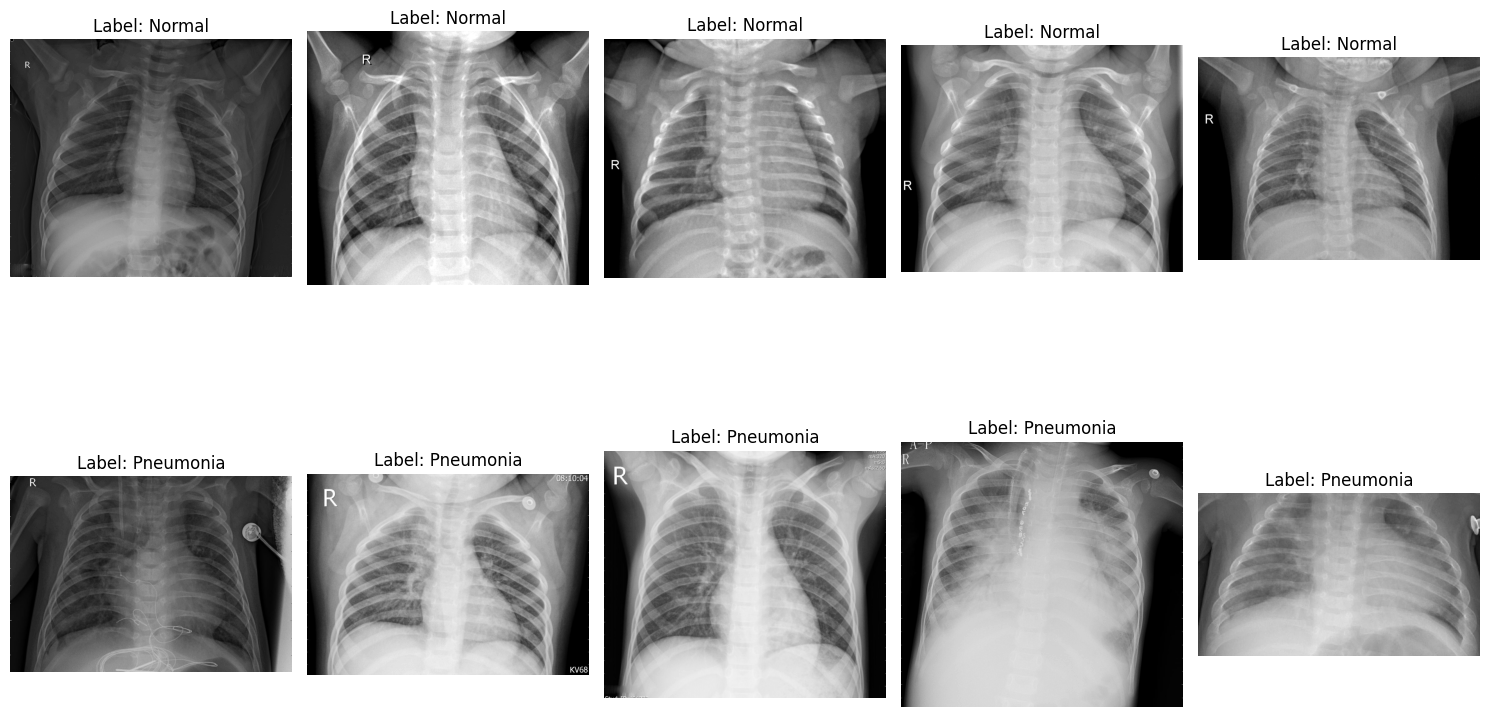

In [13]:
# Visualizing some samples from the dataset
def visualize_samples(df, n_samples=5):
    fig, axes = plt.subplots(2, n_samples, figsize=(15, 10))
    
    normal_samples = df[df['label'] == 0].iloc[:n_samples]
    pneumonia_samples = df[df['label'] == 1].iloc[:n_samples]
    # Visualize 5 NORMAL samples
    for i in range(n_samples):
        img_path = normal_samples.iloc[i, 0]
        label = normal_samples.iloc[i, 1]
        image = Image.open(img_path).convert('L')  # Open in grayscale (original format)
        axes[0, i].imshow(image, cmap='gray')
        axes[0, i].set_title(f"Label: {['Normal', 'Pneumonia'][label]}")
        axes[0, i].axis('off')
        
    # Visualize 5 PNEUMONIA samples
    for i in range(n_samples):
        img_path = pneumonia_samples.iloc[i, 0]
        label = pneumonia_samples.iloc[i, 1]
        image = Image.open(img_path).convert('L')  # Open in grayscale (original format)
        axes[1, i].imshow(image, cmap='gray')
        axes[1, i].set_title(f"Label: {['Normal', 'Pneumonia'][label]}")
        axes[1, i].axis('off')
        
    plt.tight_layout()  # Adjust the layout to minimize white space
    plt.show()

# Show 10 samples from the training data
visualize_samples(train_df)


# solve imbalance in training dataset

In [14]:
# The validation set is too small so we add this to the train data then solve the imbalanced data and split it to train and validation
df = pd.concat([train_df, val_df], ignore_index=True)

In [15]:
df.shape

(5232, 2)

In [16]:
df = pd.concat([df, test_df], ignore_index=True)

In [17]:
df.shape

(5856, 2)

In [18]:
df['label'].value_counts()

label
1    4273
0    1583
Name: count, dtype: int64

In [19]:
# Select 1,500 instances of 1
df_1 = df[df['label'] == 1].sample(n=1600, random_state=42)

# Select 1583 instances of 0
df_0 = df[df['label'] == 0]

# Concatenate the two DataFrames
df = pd.concat([df_1, df_0], ignore_index=True)

# Shuffle the new DataFrame
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [20]:
df.head(10)

,file_path,label
0,/kaggle/input/chest-xray-pneumonia/chest_xray/...,0
1,/kaggle/input/chest-xray-pneumonia/chest_xray/...,1
2,/kaggle/input/chest-xray-pneumonia/chest_xray/...,1
3,/kaggle/input/chest-xray-pneumonia/chest_xray/...,1
4,/kaggle/input/chest-xray-pneumonia/chest_xray/...,0
5,/kaggle/input/chest-xray-pneumonia/chest_xray/...,1
6,/kaggle/input/chest-xray-pneumonia/chest_xray/...,1
7,/kaggle/input/chest-xray-pneumonia/chest_xray/...,1
8,/kaggle/input/chest-xray-pneumonia/chest_xray/...,1
9,/kaggle/input/chest-xray-pneumonia/chest_xray/...,0


In [21]:
df['label'].value_counts()

label
1    1600
0    1583
Name: count, dtype: int64

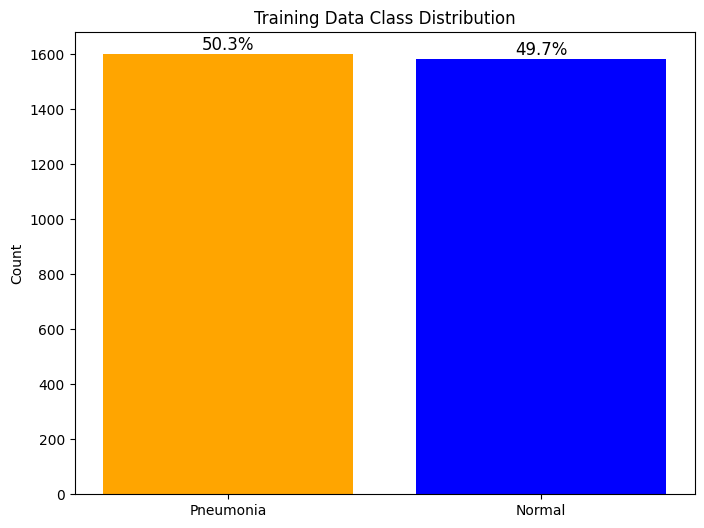

In [22]:
# Show the target
df_counts = df['label'].value_counts()

plt.figure(figsize=(8, 6))
bars = plt.bar(['Pneumonia', 'Normal'], df_counts, color=['orange', 'blue'])

# Add percentages on top of each bar
total = df_counts.sum()
for bar, count in zip(bars, df_counts):
    percentage = (count / total) * 100
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             f'{percentage:.1f}%', ha='center', va='bottom', fontsize=12)

plt.title("Training Data Class Distribution")
plt.ylabel("Count")
plt.show()


### Split the data set to train , test and validation 

In [23]:
train_df, test_df = train_test_split(df, test_size=0.15, stratify=df['label'], random_state=42)

# Display the shapes of the resulting datasets
print("Training set shape:", train_df.shape)
print("test set shape:", test_df.shape)


Training set shape: (2705, 2)
test set shape: (478, 2)


In [24]:
train_df, val_df = train_test_split(train_df, test_size=0.15, stratify=train_df['label'], random_state=42)

# Display the shapes of the resulting datasets
print("Training set shape:", train_df.shape)
print("Validation set shape:", val_df.shape)


Training set shape: (2299, 2)
Validation set shape: (406, 2)


In [25]:
train_df['label'].value_counts()

label
1    1156
0    1143
Name: count, dtype: int64

In [26]:
test_df['label'].value_counts()

label
1    240
0    238
Name: count, dtype: int64

In [27]:
val_df['label'].value_counts()

label
1    204
0    202
Name: count, dtype: int64

# Data preparation

In [28]:
# Define Dataset class
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        label = self.dataframe.iloc[idx, 1]
        img = Image.open(img_path).convert('RGB')  

        if self.transform:
            img = self.transform(img)

        return img, label


In [29]:
# For ResNet (RGB Input)
train_transform_resnet = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to RGB (3 channels)
    transforms.RandomHorizontalFlip(),  
    transforms.ToTensor(),  
])

val_transform_resnet = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to RGB (3 channels)
    transforms.ToTensor(),  
])

train_dataset_resnet = ImageDataset(train_df, transform=train_transform_resnet)
val_dataset_resnet = ImageDataset(val_df, transform=val_transform_resnet)

# DataLoader
batch_size = 32

train_loader_resnet = DataLoader(train_dataset_resnet, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader_resnet = DataLoader(val_dataset_resnet, batch_size=batch_size, shuffle=False, num_workers=2)

In [30]:
# Create Dataset and DataLoader for Test Set 
test_transform_resnet = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to 3 channels (RGB)
    transforms.ToTensor(),
])

test_dataset_resnet = ImageDataset(test_df, transform=test_transform_resnet)
test_loader_resnet = DataLoader(test_dataset_resnet, batch_size=32, shuffle=False)

# ResNet50 implementation

In [31]:
class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Bottleneck, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)
        
        self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, padding=0)
        self.batch_norm3 = nn.BatchNorm2d(out_channels*self.expansion)
        
        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()
        
    def forward(self, x):
        identity = x.clone()
        x = self.relu(self.batch_norm1(self.conv1(x)))
        
        x = self.relu(self.batch_norm2(self.conv2(x)))
        
        x = self.conv3(x)
        x = self.batch_norm3(x)
        
        #downsample if needed
        if self.i_downsample is not None:
            identity = self.i_downsample(identity)
        #add identity
        x+=identity
        x=self.relu(x)
        
        return x


In [32]:
class ResNet(nn.Module):
    def __init__(self, ResBlock, layer_list, num_classes, num_channels=3):
        super(ResNet, self).__init__()
        self.in_channels = 64
        
        self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size = 3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(ResBlock, layer_list[0], planes=64)
        self.layer2 = self._make_layer(ResBlock, layer_list[1], planes=128, stride=2)
        self.layer3 = self._make_layer(ResBlock, layer_list[2], planes=256, stride=2)
        self.layer4 = self._make_layer(ResBlock, layer_list[3], planes=512, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512*ResBlock.expansion, num_classes)
        
    def forward(self, x):
        x = self.relu(self.batch_norm1(self.conv1(x)))
        x = self.max_pool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        
        return x
        
    def _make_layer(self, ResBlock, blocks, planes, stride=1):
        ii_downsample = None
        layers = []
        
        if stride != 1 or self.in_channels != planes*ResBlock.expansion:
            ii_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, planes*ResBlock.expansion, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes*ResBlock.expansion)
            )
            
        layers.append(ResBlock(self.in_channels, planes, i_downsample=ii_downsample, stride=stride))
        self.in_channels = planes*ResBlock.expansion
        
        for i in range(blocks-1):
            layers.append(ResBlock(self.in_channels, planes))
            
        return nn.Sequential(*layers)

   

In [33]:
def ResNet50(num_classes, channels=3):
    return ResNet(Bottleneck, [3,4,6,3], num_classes, channels)
    

In [34]:
# for anther resnet architcher
"""
def ResNet101(num_classes, channels=3):
    return ResNet(Bottleneck, [3,4,23,3], num_classes, channels)

def ResNet152(num_classes, channels=3):
    return ResNet(Bottleneck, [3,8,36,3], num_classes, channels)

"""

'\ndef ResNet101(num_classes, channels=3):\n    return ResNet(Bottleneck, [3,4,23,3], num_classes, channels)\n\ndef ResNet152(num_classes, channels=3):\n    return ResNet(Bottleneck, [3,8,36,3], num_classes, channels)\n\n'

In [35]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0, path='checkpoint.pt'):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
            verbose (bool): If True, prints a message for each validation loss improvement.
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
            path (str): Path to save the model checkpoint.
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        """Saves model when validation loss decreases."""
        if self.verbose:
            print(f"Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...")
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss


In [36]:
# Define model, loss, optimizer, device ,and scheduler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet50(2)
# Move the model to the appropriate device
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001)
scheduler = ReduceLROnPlateau(optimizer, factor=0.1, patience=5)
early_stopping = EarlyStopping(patience=7, verbose=True, path='best_resnet50_model.pt')  # Define EarlyStopping


In [37]:
n_epochs =100

# Training Loop
for epoch in range(1, n_epochs + 1):
    start_time = time.time()  # Start timing
    
    # Training step
    model.train()
    train_loss = 0.0
    for data, target in train_loader_resnet: 
        data, target = data.to(device), target.to(device)  # Move data and target to the device
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation step
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in val_loader_resnet:  
            data, target = data.to(device), target.to(device)  # Move data and target to the device
            
            output = model(data)
            loss = criterion(output, target)
            val_loss += loss.item()
            _, predicted = torch.max(output, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

    val_loss /= len(val_loader_resnet)
    val_accuracy = correct / total

    # End timing
    epoch_duration = time.time() - start_time  # Calculate epoch duration

    print(f"Epoch {epoch}, Time: {epoch_duration:.2f}s, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Step the learning rate scheduler
    scheduler.step(val_loss)

    # Check for early stopping
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break

print ("Trian End")

Epoch 1, Time: 41.85s, Training Loss: 195.1622, Validation Loss: 11.1736, Validation Accuracy: 0.7044
Validation loss decreased (inf --> 11.173633).  Saving model ...
Epoch 2, Time: 34.46s, Training Loss: 69.1456, Validation Loss: 1.0887, Validation Accuracy: 0.6478
Validation loss decreased (11.173633 --> 1.088724).  Saving model ...
Epoch 3, Time: 35.17s, Training Loss: 36.8546, Validation Loss: 18.3742, Validation Accuracy: 0.5369
EarlyStopping counter: 1 out of 7
Epoch 4, Time: 34.85s, Training Loss: 37.9768, Validation Loss: 0.5850, Validation Accuracy: 0.8103
Validation loss decreased (1.088724 --> 0.584979).  Saving model ...
Epoch 5, Time: 34.68s, Training Loss: 32.1971, Validation Loss: 5.7781, Validation Accuracy: 0.8300
EarlyStopping counter: 1 out of 7
Epoch 6, Time: 35.02s, Training Loss: 54.4219, Validation Loss: 0.4183, Validation Accuracy: 0.7980
Validation loss decreased (0.584979 --> 0.418324).  Saving model ...
Epoch 7, Time: 35.58s, Training Loss: 35.8538, Validatio

In [38]:
# Load the best model after early stopping
model.load_state_dict(torch.load('best_resnet50_model.pt'))
print("Training complete. Best model loaded.")

Training complete. Best model loaded.


<ipython-input-38-eba6130ca45c>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_resnet50_model.pt'))


# model evaluation

In [39]:
correct = 0
total = 0

with torch.no_grad():
    for data in train_loader_resnet:
        images, labels = data
        images, labels = images.to('cuda'), labels.to('cuda')
        outputs = model(images)
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Train Accuracy  : ', 100*(correct/total))

Train Accuracy  :  93.17094388864724


In [40]:
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader_resnet:
        images, labels = data
        images, labels = images.to('cuda'), labels.to('cuda')
        outputs = model(images)
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Test Accuracy  : ', 100*(correct/total))

Test Accuracy  :  93.93305439330544


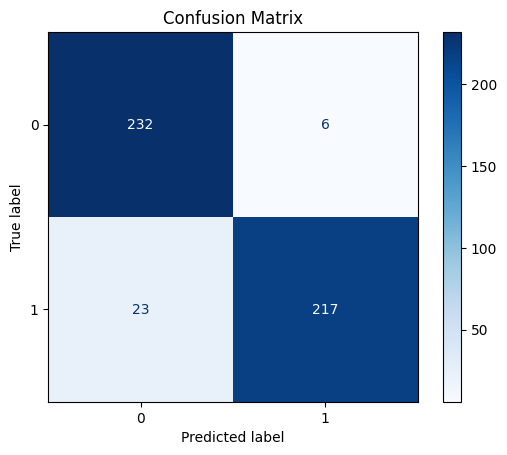

In [41]:
model.eval()  

all_preds = []
all_labels = []

with torch.no_grad():  # Disable gradient computation
    for inputs, labels in test_loader_resnet:
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        outputs = model(inputs)
        
        _, predicted = torch.max(outputs, 1)  # Get predicted classes
        all_preds.extend(predicted.cpu().numpy())  # Store predictions
        all_labels.extend(labels.cpu().numpy())   # Store true labels

# Generate the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=np.unique(all_labels))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [42]:
model.eval()

# Collect predictions and probabilities
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for inputs, labels in test_loader_resnet:
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        outputs = model(inputs)
        
        probs = torch.softmax(outputs, dim=1)  # Get probabilities for each class
        _, predicted = torch.max(outputs, 1)  # Get predicted classes
        
        all_probs.extend(probs.cpu().numpy())   # Store probabilities
        all_preds.extend(predicted.cpu().numpy())  # Store predictions
        all_labels.extend(labels.cpu().numpy())    # Store true labels

# Classification Report
print("Classification Report:")
print(classification_report(all_labels, all_preds))


Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       238
           1       0.97      0.90      0.94       240

    accuracy                           0.94       478
   macro avg       0.94      0.94      0.94       478
weighted avg       0.94      0.94      0.94       478



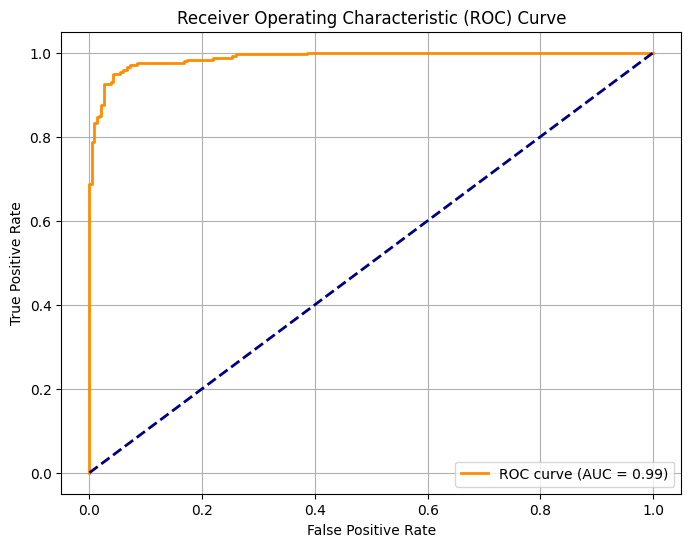

AUC: 0.99


In [43]:
import torch
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
def get_predictions_and_labels(model, dataloader, device):
    model.eval()
    predictions = []
    true_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            
            probs = torch.softmax(outputs, dim=1)[:, 1]  # Take the probability for the positive class
            predictions.extend(probs.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    return predictions, true_labels

# Get predictions and true labels
predictions, true_labels = get_predictions_and_labels(model, test_loader_resnet, device)

# Calculate ROC and AUC
fpr, tpr, _ = roc_curve(true_labels, predictions)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Print AUC value
print(f"AUC: {roc_auc:.2f}")


Balanced Predictions from Pretrained ResNet50:


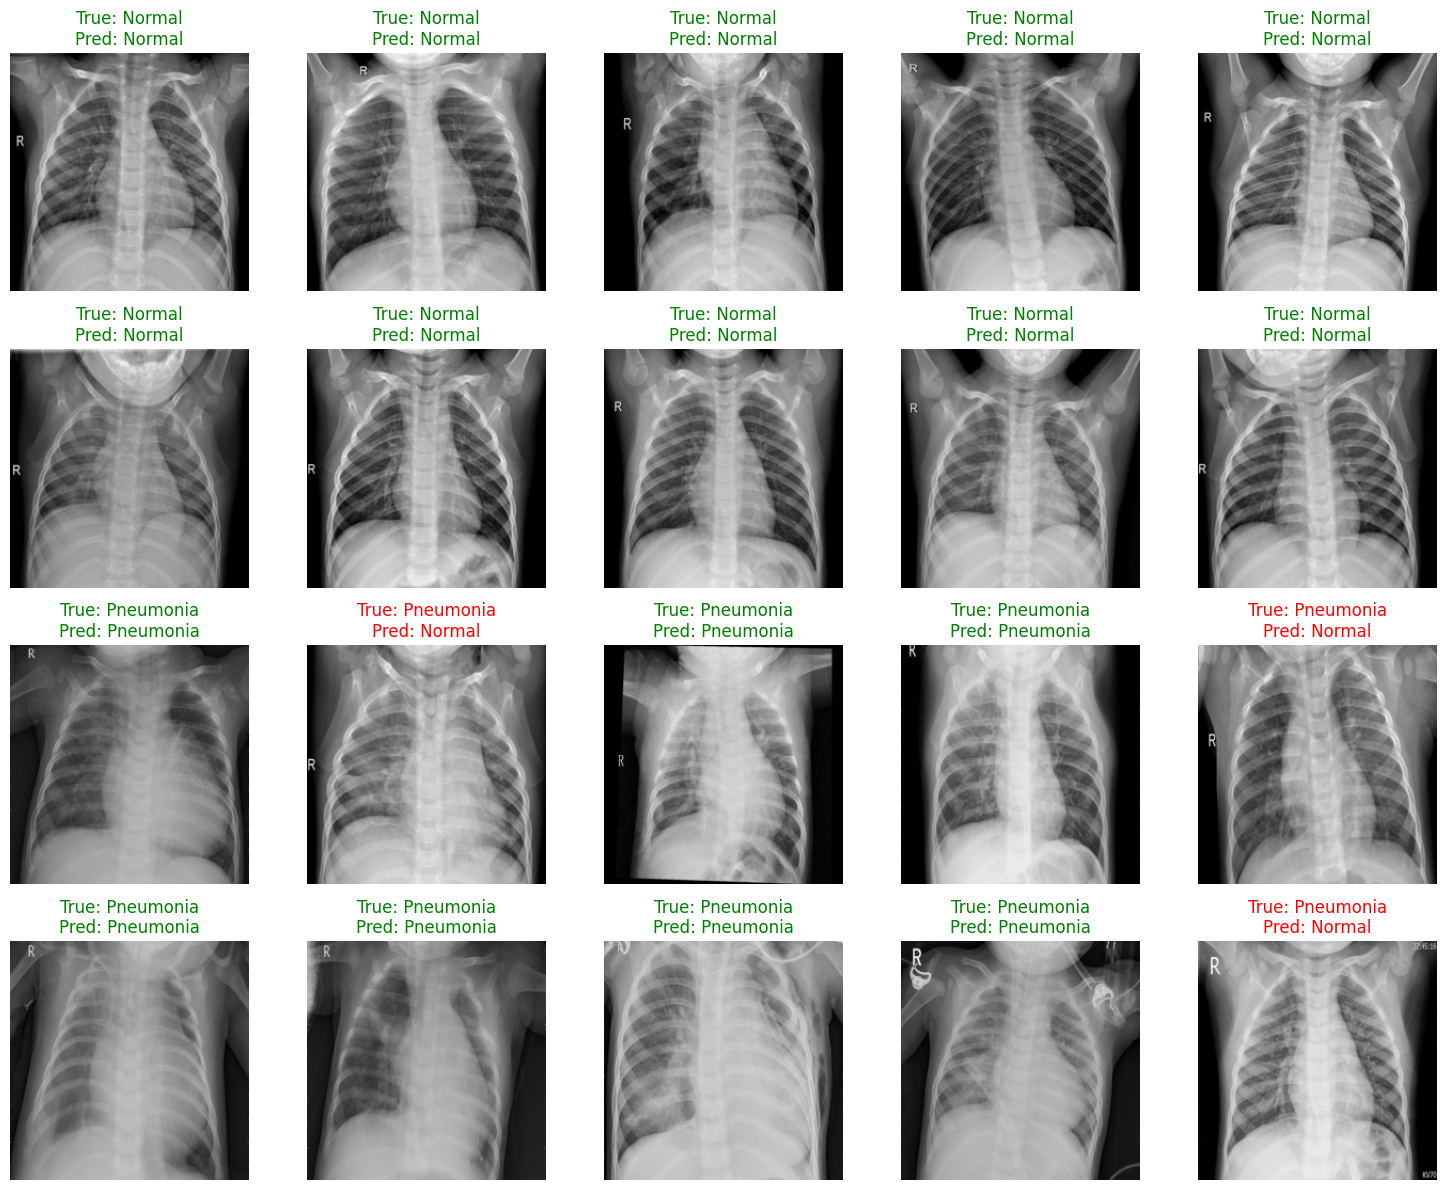

In [44]:
def show_balanced_predictions(model, loader, class_names, num_normal=10, num_pneumonia=10):
    """
    Display images with balanced true labels (Normal and Pneumonia).
    Highlight incorrect predictions in red.
    """
    model.eval()  
    normal_images = []
    pneumonia_images = []

    # Gather predictions for "Normal" and "Pneumonia" separately
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)
            
            for i in range(images.size(0)):
                # Convert image tensor to numpy array for display
                image = images[i].cpu().numpy().transpose(1, 2, 0)
                if image.shape[-1] == 1:  # Grayscale image
                    image = image.squeeze(-1)

                true_label = labels[i].item()
                pred_label = predictions[i].item()
                label_dict = {
                    "image": image,
                    "true_label": class_names[true_label],
                    "pred_label": class_names[pred_label],
                    "correct": true_label == pred_label,
                }

                # Collect images based on true labels
                if true_label == 0 and len(normal_images) < num_normal:
                    normal_images.append(label_dict)
                elif true_label == 1 and len(pneumonia_images) < num_pneumonia:
                    pneumonia_images.append(label_dict)

            # Break the loop if we have enough images
            if len(normal_images) >= num_normal and len(pneumonia_images) >= num_pneumonia:
                break

    # Combine images for display
    images_to_display = normal_images + pneumonia_images
    rows, cols = 4, 5  # Grid size
    fig, axes = plt.subplots(rows, cols, figsize=(15, 12))

    for idx, ax in enumerate(axes.flat):
        if idx < len(images_to_display):
            img_dict = images_to_display[idx]
            image = img_dict["image"]
            true_label = img_dict["true_label"]
            pred_label = img_dict["pred_label"]
            correct = img_dict["correct"]

            # Title with green for correct, red for incorrect
            title_color = "green" if correct else "red"
            ax.imshow(image, cmap="gray" if image.ndim == 2 else None)
            ax.set_title(f"True: {true_label}\nPred: {pred_label}", color=title_color)
            ax.axis("off")
        else:
            ax.axis("off")  # Empty cells

    plt.tight_layout()
    plt.show()


# Show predictions for Pretrained ResNet50
print("Balanced Predictions from Pretrained ResNet50:")
show_balanced_predictions(model, test_loader_resnet, class_names=["Normal", "Pneumonia"], num_normal=10, num_pneumonia=10)